In [1]:
import captum.attr as ca
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import torch
import matplotlib.pyplot as plt
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule, IdentityRule
from captum.attr import visualization as viz

from pyment_th.model import sfcn_bin as sb
from pyment_th.model.utils.etc import WeightRepository
from pyment_th.model.utils.nn_utils import Conv3DSame

In [2]:
WEIGHT_PATH = '../.pyment/pyment/data/sfcn-binexplainable-dementia.h5'

model = sb.BinarySFCN(prediction_range=None)
torch_weights = WeightRepository.convert_to_torch(WEIGHT_PATH, model.state_dict(), model_type="sfcn-bin")
model.load_state_dict(torch_weights)

<All keys matched successfully>

In [3]:
model

BinarySFCN(
  (fn1): Sequential(
    (sfcn-bin_block1_conv): Conv3DSame(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-bin_block1_norm): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-bin_block1_relu): ReLU()
    (sfcn-bin_block1_pool): MaxPool3dIndices(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sfcn-bin_block2_conv): Conv3DSame(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-bin_block2_norm): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-bin_block2_relu): ReLU()
    (sfcn-bin_block2_pool): MaxPool3dIndices(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sfcn-bin_block3_conv): Conv3DSame(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-bin_block3_norm): BatchNorm3d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-bin_block3_relu): ReL

In [4]:
LABELS_FILE = "../test_data/IXI/IXI.xls"
IMAGE_FOLDER = "../test_data/IXI"

labels = pd.read_excel(LABELS_FILE)
labels.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [5]:
for subject in tqdm(os.listdir(IMAGE_FOLDER)):#
    if "IXI" in subject and os.path.isdir(os.path.join(IMAGE_FOLDER, subject)):
        path = os.path.join(IMAGE_FOLDER, subject, 'anat', 'cropped_T1w.nii.gz')
        subjectid = int(subject[7:])
        if not os.path.isfile(path):
            print(f'Skipping {subject}: Missing cropped.nii.gz')
            continue
        elif subjectid not in labels['IXI_ID'].values:
            print(f'Skipping {subject}: Missing labels')
            continue

        age = labels.loc[labels['IXI_ID'] == subjectid, 'AGE'].values[0]
        
        img = nib.load(path)
        img : np.ndarray = img.get_fdata()
        img = np.expand_dims(img, 0)

        break

  0%|          | 0/87 [00:00<?, ?it/s]


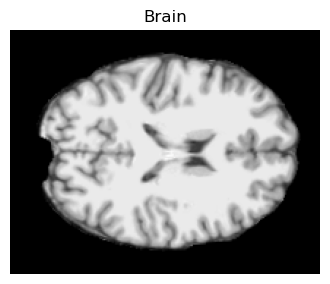

In [6]:
plt.figure(figsize=(4, 4))
plt.imshow(img[0,:,:,95], cmap="gray")
plt.title("Brain")
plt.axis("off")
plt.show()

In [7]:
img.shape

(1, 167, 212, 160)

In [8]:
from pyment_th.utils.transforms import Resize3D

In [9]:
model.eval()
torch_img = torch.from_numpy(img).float().unsqueeze(0)

In [10]:
output = model(torch_img)
output

tensor([[0.1212]], grad_fn=<SigmoidBackward0>)

In [11]:
from pyment_th.lrp.utils import get_layer_keys_before_lrp, expand_model
from pyment_th.lrp.rules import AllOnesRule

get_layer_keys_before_lrp(model)

['fn1.sfcn-bin_block1_conv',
 'fn1.sfcn-bin_block1_pool',
 'fn1.sfcn-bin_block2_conv',
 'fn1.sfcn-bin_block2_pool',
 'fn1.sfcn-bin_block3_conv',
 'fn1.sfcn-bin_block3_pool',
 'fn1.sfcn-bin_block4_conv',
 'fn1.sfcn-bin_block4_pool',
 'fn1.sfcn-bin_block5_conv',
 'fn1.sfcn-bin_block5_pool',
 'fn1.sfcn-bin_top_conv',
 'fn1.sfcn-bin_top_pool',
 'linear.sfcn-bin_predictions']

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

from captum.attr._utils.lrp_rules import PropagationRule
from pyment_th.model.utils.nn_utils import MaxPool3dIndices

class WinnerTakesAll(PropagationRule):
    """
    Sets all weights and inputs to ones, similar to the "flat" mode in the TF implementation.
    """
    def __init__(self, name):
        super().__init__()
        self.name = name

    def _manipulate_weights(self, module: MaxPool3dIndices, inputs, outputs):
        pass
        
    def _create_backward_hook_input(self, inputs):
        def _backward_hook_input(grad):
            print("Inputs", self.name, grad[grad != 0])
            relevance = grad * inputs
            device = grad.device
            if self._has_single_input:
                self.relevance_input[device] = relevance.data
            else:
                self.relevance_input[device].append(relevance.data)

            # replace_out is needed since two hooks are set on the same tensor
            # The output of this hook is needed in backward_hook_activation
            grad.replace_out = relevance
            return relevance

        return _backward_hook_input

    def _create_backward_hook_output(self, outputs):
        def _backward_hook_output(grad):
            print("Outputs", self.name, grad[grad != 0])
            self.relevance_output[grad.device] = grad.data
            return grad

        return _backward_hook_output

In [13]:
rules = {'fn1.sfcn-bin_block1_conv': AllOnesRule(),
 'fn1.sfcn-bin_block2_conv': AllOnesRule(),
 'fn1.sfcn-bin_block3_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-bin_block4_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-bin_block5_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-bin_top_conv': Alpha1_Beta0_Rule(),
 'linear.sfcn-bin_predictions':EpsilonRule(0.25),
 'fn1.sfcn-bin_block1_pool': WinnerTakesAll(1),
 'fn1.sfcn-bin_block2_pool': WinnerTakesAll(2),
 'fn1.sfcn-bin_block3_pool': WinnerTakesAll(3),
 'fn1.sfcn-bin_block4_pool': WinnerTakesAll(4),
 'fn1.sfcn-bin_block5_pool': WinnerTakesAll(5),
 'fn1.sfcn-bin_top_conv': EpsilonRule(1e-9),
 'fn1.sfcn-bin_top_pool': EpsilonRule(1e-9)}

In [14]:
from pyment_th.lrp.applier import LRPApplier

lrpappl = LRPApplier(model, rules)

In [15]:
attributions_lrp = lrpappl.attribute(torch.from_numpy(img).float().unsqueeze(0).requires_grad_())

Outputs EpsilonRule tensor([-0.4482])
Inputs EpsilonRule tensor([-0.0538, -0.1146, -0.0876, -0.0630, -0.1019, -0.1134, -0.0837, -0.1030,
        -0.1155, -0.1203, -0.1715, -0.1257, -0.1495, -0.1118, -0.1146, -0.1424,
        -0.1403, -0.0776, -0.0966, -0.1159, -0.1224, -0.1400, -0.1074, -0.0993,
        -0.1656, -0.1104, -0.0921, -0.1116, -0.1574, -0.1262, -0.0998, -0.0981,
        -0.1017, -0.1461, -0.0774, -0.1040, -0.1268, -0.0896, -0.1558, -0.1336,
        -0.1281, -0.1493, -0.0627, -0.1503, -0.1467, -0.1315, -0.1301, -0.1405,
        -0.1467, -0.1083, -0.1151, -0.1341,  0.0715, -0.1135, -0.0675, -0.1159,
        -0.1497, -0.1070, -0.1260, -0.1227, -0.1038, -0.1338, -0.1269, -0.1053])
Outputs EpsilonRule tensor([-0.0538, -0.1146, -0.0876, -0.0630, -0.1019, -0.1134, -0.0837, -0.1030,
        -0.1155, -0.1203, -0.1715, -0.1257, -0.1495, -0.1118, -0.1146, -0.1424,
        -0.1403, -0.0776, -0.0966, -0.1159, -0.1224, -0.1400, -0.1074, -0.0993,
        -0.1656, -0.1104, -0.0921, -0.1116

In [16]:
attributions_lrp.shape, img.shape

(torch.Size([1, 1, 167, 212, 160]), (1, 167, 212, 160))

In [17]:
attributions_lrp[0,0][img[0] == 0] = 0

In [18]:
attributions_lrp = attributions_lrp / torch.amax(torch.abs(attributions_lrp))

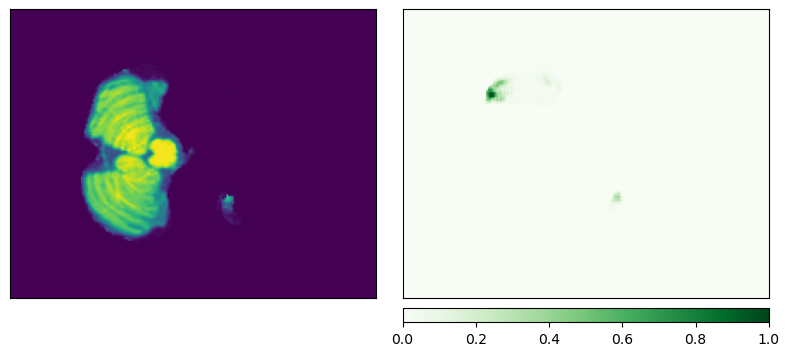

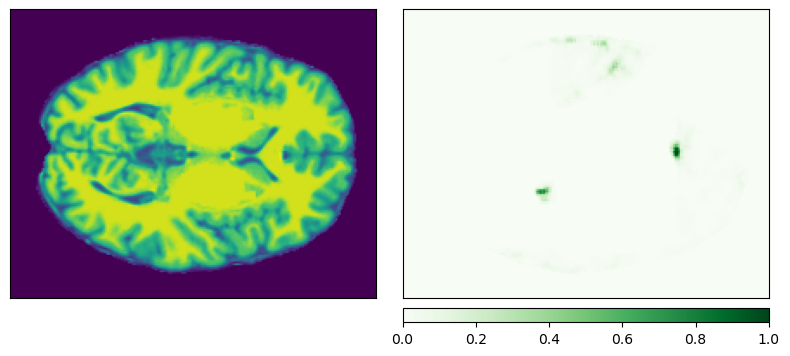

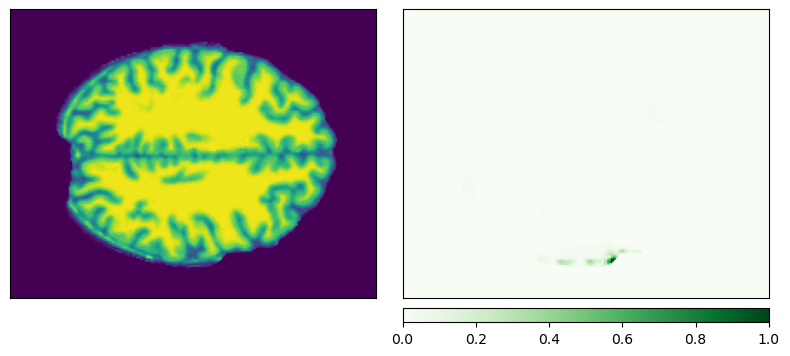

In [19]:
_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[30]],
                                      img.squeeze()[:,:,[30]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[80]],
                                      img.squeeze()[:,:,[80]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[110]],
                                      img.squeeze()[:,:,[110]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

In [24]:
# Compare with original
from explainability import LRP, LRPStrategy

from pyment.models import BinarySFCN, RegressionSFCN
from pyment.postprocessing import get_postprocessing

MODEL = BinarySFCN
WEIGHTS = 'dementia-2024'
LRP_STRATEGY = LRPStrategy(
    layers=[
        {'flat': True},
        {'flat': True},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'alpha': 1, 'beta': 0},
        {'epsilon': 0.25},
    ]
)

model_esten = MODEL(weights=WEIGHTS)
explainer = LRP(model_esten, layer=-1, idx=0, strategy=LRP_STRATEGY)

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [25]:
model_esten.layers[-2].name_scope

<bound method Layer._name_scope of <keras.src.layers.regularization.dropout.Dropout object at 0x406ca9c10>>

In [26]:
prediction = model_esten.predict(img, verbose=0)[0]
prediction = model_esten.postprocess(prediction)
prediction

array(0.12117125, dtype=float32)

In [27]:
explanation = explainer.predict(img, verbose=0)[0,...,0]

In [28]:
explanation[img[0] == 0] = 0

In [29]:
explanation.shape

(167, 212, 160)

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


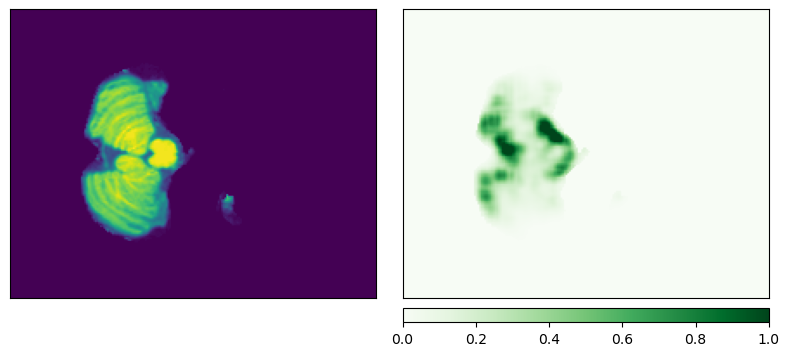

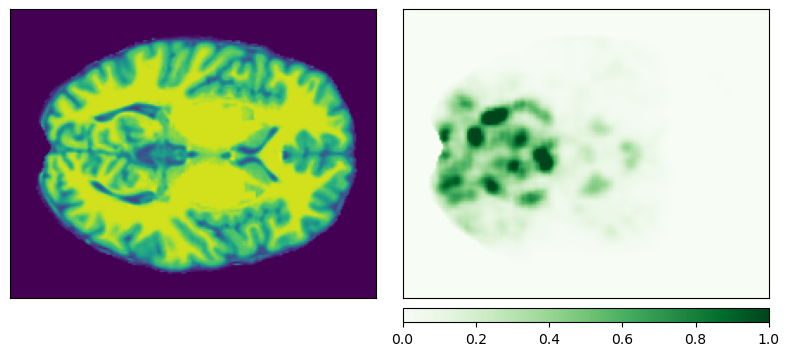

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


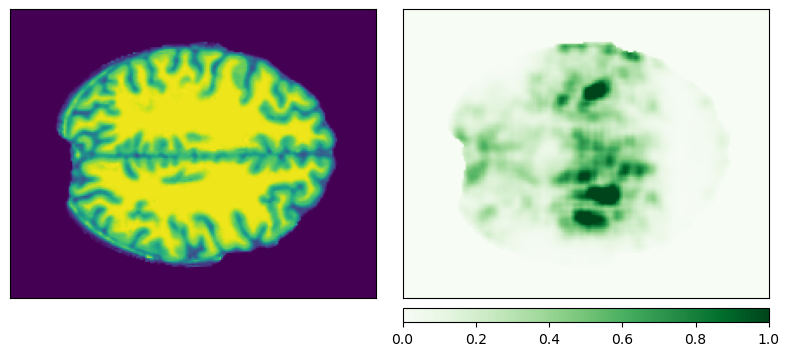

In [30]:
_ = viz.visualize_image_attr_multiple(explanation[:,:,[30]],
                                      img.squeeze()[:,:,[30]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=10)

_ = viz.visualize_image_attr_multiple(explanation[:,:,[80]],
                                      img.squeeze()[:,:,[80]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=10)

_ = viz.visualize_image_attr_multiple(explanation[:,:,[110]],
                                      img.squeeze()[:,:,[110]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=10)

In [31]:
from zennit.rules import Epsilon, Flat, AlphaBeta, BasicHook, NoMod
from copy import deepcopy

new_model = deepcopy(model)

In [32]:
from zennit.canonizers import SequentialMergeBatchNorm

# create the canonizer
canonizer = SequentialMergeBatchNorm()

# apply the canonizer to the model, which creates multiple canonizer
# instances, one per applicable case
instances = canonizer.apply(new_model)

In [33]:
from zennit.core import Hook, BasicHook, Stabilizer, expand, ParamMod

class WinnerTakesAllTest(BasicHook):

    def __init__(self, epsilon=1e-9, zero_params=None, name = ""):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[NoMod(zero_params=zero_params)],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0]),
        )
        self.name = name

    def backward(self, module, grad_input, grad_output):
        original_input = self.stored_tensors['input'][0].clone()
        inputs = []
        outputs = []
        for in_mod, param_mod, out_mod in zip(self.input_modifiers, self.param_modifiers, self.output_modifiers):
            input = in_mod(original_input).requires_grad_()
            with ParamMod.ensure(param_mod)(module) as modified, torch.autograd.enable_grad():
                output = modified.forward(input)
                output = out_mod(output)
            inputs.append(input)
            outputs.append(output)
        grad_outputs = self.gradient_mapper(grad_output[0], outputs)
        print("Outputs", self.name, grad_output[0][grad_output[0] != 0])
        gradients = torch.autograd.grad(
            outputs,
            inputs,
            grad_outputs=grad_outputs,
            create_graph=grad_output[0].requires_grad
        )
        print("Inputs", self.name, gradients[0][gradients[0] != 0])
        relevance = self.reducer(inputs, gradients)
        return tuple(relevance if original.shape == relevance.shape else None for original in grad_input)

In [34]:
rules : dict[str, BasicHook] = {'fn1.sfcn-bin_block1_conv': Flat(1e-9),
 'fn1.sfcn-bin_block2_conv': Flat(1e-9),
 'fn1.sfcn-bin_block3_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-bin_block4_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-bin_block5_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-bin_top_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'linear.sfcn-bin_predictions': Epsilon(0.25),
 'fn1.sfcn-bin_top_pool': Epsilon(1e-9),
 'fn1.sfcn-bin_top_conv': Epsilon(1e-9)}

In [35]:
handles = []
for key, layer in expand_model(new_model.named_children()):
    if key in rules:
        handles.append(rules[key].register(layer))

In [36]:
ipt = torch.from_numpy(img).float().unsqueeze(0).requires_grad_()
output = new_model(ipt)
output

tensor([[0.1210]], grad_fn=<SigmoidBackward0>)

In [37]:
attribution, = torch.autograd.grad(
    output, ipt, grad_outputs=torch.ones_like(output)
)

In [38]:
attribution.shape

torch.Size([1, 1, 167, 212, 160])

In [39]:
attribution[0,0][img[0] == 0] = 0

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


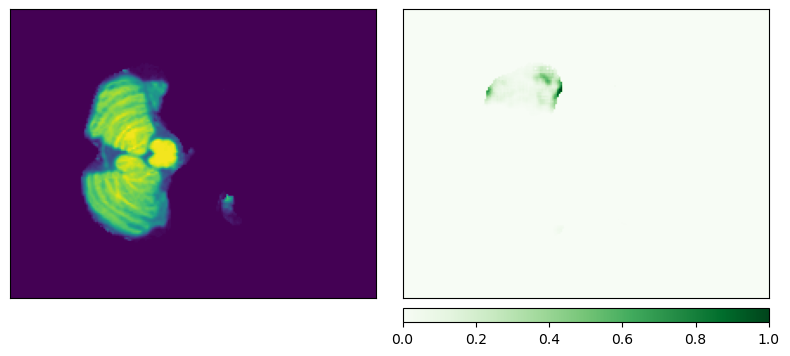

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


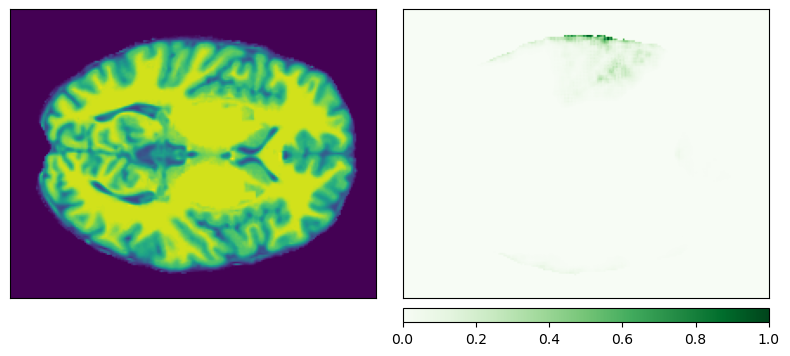

/Users/kingpowa/miniconda3/envs/pyment/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:51: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


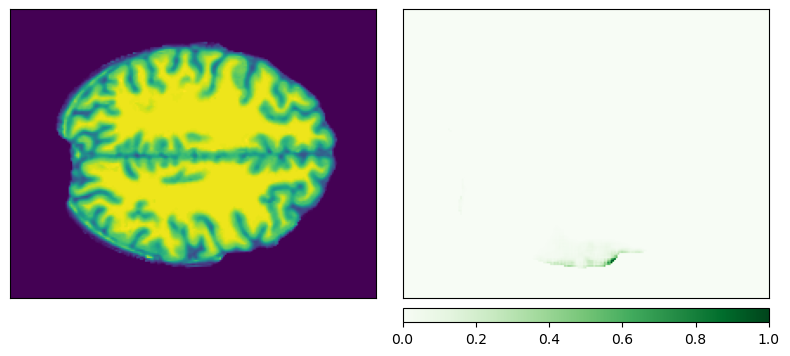

In [40]:
_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[30]],
                                      img.squeeze()[:,:,[30]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[80]],
                                      img.squeeze()[:,:,[80]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[110]],
                                      img.squeeze()[:,:,[110]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)